# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://course.cse.ust.hk/comp4901j/Password_Only/programs/assignment1/index.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [5]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        auc_val = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = (np.mean(y_train == y_train_pred), auc_val)
        if auc_val > best_val:
            best_val = auc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.106449 val accuracy: 0.099000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.089735 val accuracy: 0.091000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.412878 val accuracy: 0.411000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.092388 val accuracy: 0.100000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.417918 val accuracy: 0.417000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.404388 val accuracy: 0.399000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.415653 val accuracy: 0.416000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.399408 val accuracy: 0.391000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.332816 val accuracy: 0.334000
best validation accuracy achieved during cross-validation: 0.417000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.419


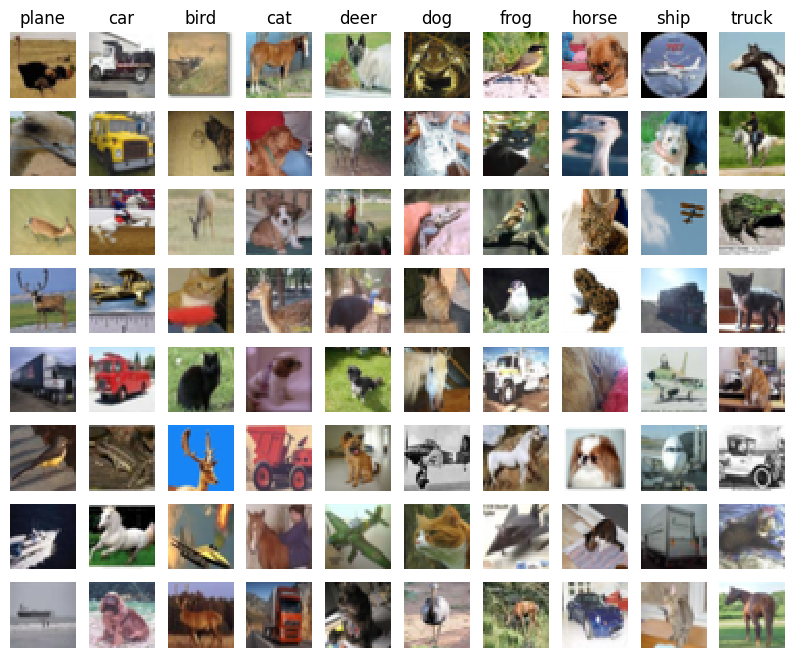

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

- Some figures with similar shape and color to the wrong class is misclassified. This makes sense because we train on the top of HOG and HSV features.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print(X_train_feats.shape)

(49000, 155)


In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

learning_rates = [6e-1, 5.5e-1]
regularization_strengths = [2.5e-4, 4e-4]

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
results = {}
best_val = -1
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1960, batch_size=500,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=rs, verbose=False)
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        results[(lr, rs)] = ((net.predict(X_train_feats) == y_train).mean(), val_acc)
        #print(f'bs={bs} hs={hs} lr={lr} reg={reg} Validation accuracy={val_acc}')
        if val_acc > best_val:
            best_val = val_acc
            best_net = net

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 5.500000e-01 reg 2.500000e-04 train accuracy: 0.739571 val accuracy: 0.608000
lr 5.500000e-01 reg 4.000000e-04 train accuracy: 0.726816 val accuracy: 0.592000
lr 6.000000e-01 reg 2.500000e-04 train accuracy: 0.751796 val accuracy: 0.583000
lr 6.000000e-01 reg 4.000000e-04 train accuracy: 0.744612 val accuracy: 0.595000
best validation accuracy achieved during cross-validation: 0.608000


In [9]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.593


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

In [12]:
# Modified HOG function

def my_hog_feature(im):
    """Compute Histogram of Gradient (HOG) feature for an image
  
       Modified from skimage.feature.hog
       http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog
     
     Reference:
       Histograms of Oriented Gradients for Human Detection
       Navneet Dalal and Bill Triggs, CVPR 2005
     
    Parameters:
      im : an input grayscale or rgb image
      
    Returns:
      feat: Histogram of Gradient (HOG) feature
    
      """
  
    # convert rgb to grayscale if needed
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    sx, sy = image.shape # image size
    orientations = 12 # number of gradient bins
    cx, cy = (4, 4) # pixels per cell

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y
    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                        grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                        temp_ori, 0)
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[cx//2::cx, cy//2::cy].T
  
    return orientation_histogram.ravel()

# Bag Attempt:
def bag_feature(im):
    sx, sy, sz = im.shape
    cx, cy = (4, 4)
    
    nx, ny = int(np.floor(sx/cx)), int(np.floor(sy/cy))
    
    feat = []
    
    for i in range(nx):
        for j in range(ny):
            xl, xr = i * cx, (i + 1) * cx - 1
            yl, yu = j * cy, (j + 1) * cy - 1
            for k in range(sz):
                feat.append(np.sqrt(np.mean(np.square(im[xl : xr, yl : yu, k]))))
            
    return np.array(feat)

In [15]:
num_color_bins = 10 # Number of bins in the color histogram
my_feature_fns = [my_hog_feature, bag_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
my_X_train_feats = extract_features(X_train, my_feature_fns, verbose=True)
my_X_val_feats = extract_features(X_val, my_feature_fns)
my_X_test_feats = extract_features(X_test, my_feature_fns)

# Preprocessing: Subtract the mean feature
my_mean_feat = np.mean(my_X_train_feats, axis=0, keepdims=True)
my_X_train_feats -= my_mean_feat
my_X_val_feats -= my_mean_feat
my_X_test_feats -= my_mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
my_std_feat = np.std(my_X_train_feats, axis=0, keepdims=True)
my_X_train_feats /= my_std_feat
my_X_val_feats /= my_std_feat
my_X_test_feats /= my_std_feat

# Preprocessing: Add a bias dimension
my_X_train_feats = np.hstack([my_X_train_feats, np.ones((my_X_train_feats.shape[0], 1))])
my_X_val_feats = np.hstack([my_X_val_feats, np.ones((my_X_val_feats.shape[0], 1))])
my_X_test_feats = np.hstack([my_X_test_feats, np.ones((my_X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [16]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = my_X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

learning_rates = [6e-1, 5.5e-1]
regularization_strengths = [2.5e-4, 4e-4]

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
results = {}
best_val = -1
best_net = None

for lr in learning_rates:
    for rs in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        # Train the network
        stats = net.train(my_X_train_feats, y_train, my_X_val_feats, y_val,
            num_iters=1960, batch_size=500,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=rs, verbose=False)
        val_acc = (net.predict(my_X_val_feats) == y_val).mean()
        results[(lr, rs)] = ((net.predict(my_X_train_feats) == y_train).mean(), val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_net = net

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

test_acc = (best_net.predict(my_X_test_feats) == y_test).mean()
print(test_acc)

lr 5.500000e-01 reg 2.500000e-04 train accuracy: 0.995184 val accuracy: 0.652000
lr 5.500000e-01 reg 4.000000e-04 train accuracy: 0.993143 val accuracy: 0.653000
lr 6.000000e-01 reg 2.500000e-04 train accuracy: 0.996571 val accuracy: 0.646000
lr 6.000000e-01 reg 4.000000e-04 train accuracy: 0.995020 val accuracy: 0.661000
best validation accuracy achieved during cross-validation: 0.661000
0.643


**Explanation**

- How to extract features?
    - The `bag_feature` function divides the raw image into 4x4 grids, and take the mean of square of values as a feature. It scans through all channels.
    - And the `my_hog_feature` function is modified from the provided `hog_feature` function. I increae the \# of orientations and divide the image into smaller (4x4) grids.
- Why these may improve the score?
    - The original implementation does not contain the raw information of the graph, instead, only the features remain. So `bag_feature` works as a complement to preserve and compress the original image
    - Increasing \# of orientations and dividing into smaller grids may provide more delicate information
    
**Experiment**

- replace `hog_feature` by `my_hog_feature`
- add `bag_feature`
- cross-validate on same set of parameter

**Result**

- The historical validation accuracies are about 0.04 ~ 0.06 higher than the baseline
- The test accuracy is about 0.05 higher than the baseline

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

- Other questions: Can these be applied to other classification tasks like posture, facial expression?
- Idea: We can try to find some ways to also train the hyperparamter
    - motivation: (1) the hyperparameters spread a wide range, which is hard for us to pick the optimal value. (2) a single experiment of a set of hyperparameters can be very time-consuming, not to say running experiments again and again.
    - implementation: derive the gradient of loss w.r.t. hyperparameter? And can use a relatively large learning rate so as to save time.